In [25]:
%config IPCompleter.greedy=True
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,OneHotEncoder

sns.set(style="darkgrid")

In [21]:
class Activations():
    def use(value,activation='relu'):
        if(activation == 'relu'):
            return Activations.relu(value)
        elif(activation == 'sigmoid'):
            return Activations.sigmoid(value)
        elif(activation == 'lu'):
            return value
        elif(activation == 'lrelu'):
            return Activations.leakyrelu(value)
    def useDerivative(value,activation='relu'):
        if(activation == 'relu'):
            return Activations.relu_grad(value)
        elif(activation == 'sigmoid'):
            return Activations.sigmoid_grad(value)
        elif(activation == 'lu'):
            return 1
        elif(activation == 'lrelu'):
            return Activations.lrelu_grad(value)
    
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))
    def relu(x):
        return np.maximum(0,x)
    def leakyrelu(x):
        return np.where(x > 0, x, x * 0.01)

    def sigmoid_grad(output):
        return output * (1.0 - output)
    def relu_grad(output):
        return np.greater(output, 0).astype(int)
    def lrelu_grad(output):
        y = np.less(output,0)
        c = output.copy()
        c[y] = 0.01
        c[~y] = 1
        return c

class Layer(object):
    def __init__(self):
        pass
    
    def compile(self):
        pass
    
    def activate(self,x):
        pass

class InputLayer(Layer):
    def __init__(self,input_dim):
        self.input_dim = input_dim
        self.units = input_dim
        self.name = "InputLayer"
    
    def activate(self,x):
        self.lastActivation = x
        return x
    
class DenseLayer(Layer):
    def __init__(self,units,activation='relu',name="DenseLayer"):
        self.weights = []
        self.bias = None
        self.units = units
        self.input_dim = 0
        self.velocity = 0
        self.name = name
        self.activation = activation

    # Initialize weights
    def compile(self):
        #self.weights = np.random.randn(self.input_dim,self.units)
        self.weights = np.random.normal(0, 1, size=(self.input_dim,self.units)) * 2/self.input_dim # Xavier Initialization
        self.bias = 0.01
    
    # Activate all neurons in the layer
    def activate(self,x):
        net = np.dot(x,self.weights) + self.bias
        net = Activations.use(net,self.activation)
        self.lastActivation = net
        return net
    
    def get_derivative(self,x):
        return Activations.useDerivative(x,self.activation)

In [125]:
class Model():
    # lr = learning_rate.
    # lrDecay = lower learning rate by half for every lrDecay epochs.
    # momentum = SGD Momentum for avoiding local minimums.
    # statFreq = Print MSE and epoch every statFreq epoch.
    def __init__(self,lr = 0.001,lrDecay=0,batchSize=64,momentum=0.9,statFreq=40):
        self.layers = []
        self.layerCount = 0
        self.lr = lr
        self.initLr = lr
        self.lrDecay = lrDecay
        self.batchSize = batchSize
        self.momentum = momentum
        self.statFreq = statFreq
        
    # Adds new layer to the model
    def Add(self,layer):
        if(not isinstance(layer,Layer)):
            raise Exception("Parameter should be type of Layer.")
        
        if(self.layerCount == 0 and not isinstance(layer,InputLayer)):
            raise Exception("First Layer should be type of Input Layer.")
        
        self.layers.append(layer)
        self.layerCount += 1
    
    def Clear(self):
        self.layers = []
        self.layerCount = 0
        self.lr = self.initLr
    
    # Compiles all layers in the models. Infers input dimensions for layers.
    def compile(self):
        for i in range(1,self.layerCount):
            dim = self.layers[i - 1].units
            self.layers[i].input_dim = dim
            self.layers[i].compile()
    
    # Train the neural network using SGD.
    def train(self,X,y,epoch = 10):  
        history = pd.DataFrame({'epoch':[None],'loss':[None]})
        x_batches = np.array_split(X,len(X) / self.batchSize)
        y_batches = np.array_split(y,len(y) / self.batchSize)

        for e in range(1,epoch):
            loss = 0
            for (x_batch,y_batch) in zip(x_batches,y_batches):
                loss += self.backPropagate(x_batch,y_batch)
            if(e > 10):
                history.loc[history.shape[0]] = [e,loss]
            if(self.lrDecay > 0 and e % self.lrDecay == 0):
                self.lr = self.lr / 2 # Decay learning rate by half
            if(e % self.statFreq == 0 or e==epoch-1):
                print(f'Epoch: {e}, mse: {loss}')
        self.history = history
        return history

    def saveWeights(self,fileName):
        weights = []
        for i in range(1,self.layerCount):
            weights.append(self.layers[i].weights)
        weightFile = open(fileName,'wb')
        pickle.dump(weights,weightFile)
        weightFile.close()
        print("Saved weights to ",fileName)
    
    def loadWeights(self,fileName):
        weightFile = open(fileName,'rb')
        weights = pickle.load(weightFile)
        weightFile.close()
        
        for i in range(1,self.layerCount):
            self.layers[i].weights = weights[i - 1]
        print("Loaded weights from ",fileName)
    
    def plotHistory(self):
        fig = plt.figure(figsize=(10,7.5))
        ax = sns.lineplot(x='epoch',y='loss',color='orange',data=self.history)
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss')
        plt.show()
    
    def predict(self,x):
        return self.feedForward(x)
        
    def feedForward(self,x):
        for layer in self.layers:
            x = layer.activate(x)
        return np.array(x)
    
    def backPropagate(self,x,y):
        output_layer = self.layers[-1]
        
        output = self.feedForward(x) # Network Output
        output_error = y - output # Output Error (y - pred)
        self.layers[-1].delta = (output_error * output_layer.get_derivative(output)) # df * error

        for i in range(self.layerCount - 2,0,-1):
            nextLayer = self.layers[i +  1]
            currentLayer = self.layers[i]
            
            error = np.dot(nextLayer.delta,nextLayer.weights.T)
            gradient = currentLayer.get_derivative(currentLayer.lastActivation)
            delta = error * gradient
            self.layers[i].delta = delta 

        # Update Weights
        for i in range(1,self.layerCount):
            d = self.layers[i].delta
            w = self.layers[i].weights
            v = self.layers[i].velocity
            
            o = np.dot(self.layers[i-1].lastActivation.T,d)
            
            self.layers[i].velocity = (self.momentum * v) + (self.lr * o) # SGD Momentum
            self.layers[i].weights += self.layers[i].velocity
            self.layers[i].bias += self.lr * np.sum(self.layers[i].delta)
        
        return np.mean(np.square(output_error))

In [141]:
class Datasets():
    def dataset_1():
        dataset = "data_regression1.txt"
        df = pd.read_csv(dataset,delimiter=',',header=None,names=['feature','output'])

        x_train,x_test,y_train,y_test = train_test_split(df['feature'].values,df['output'].values,test_size=0.3)
        
        x_train = x_train.reshape(-1,1)
        x_test = x_test.reshape(-1,1)
        y_train = y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)
        
        feature_scaler = StandardScaler()
        feature_scaler.fit(x_train)
        x_train = feature_scaler.transform(x_train)
        x_test = feature_scaler.transform(x_test)
        
        output_scaler = MinMaxScaler(feature_range=(0, 1))
        output_scaler.fit(y_train)
        y_train = output_scaler.transform(y_train)
        y_test = output_scaler.transform(y_test)

        return x_train,x_test,y_train,y_test,output_scaler

    def dataset_2():
        number_of_items = 2000
        noise = 0.5
        freq = 1.75
        X = np.linspace(0,freq*np.pi,number_of_items)
        Y = np.sin(X) * 2
        n = np.random.rand(number_of_items)
        n = np.random.normal(0, 1, number_of_items) * noise
        Y = Y + n

        x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3)
        
        x_train = x_train.reshape(-1,1)
        x_test = x_test.reshape(-1,1)
        y_train = y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)
        
        feature_scaler = StandardScaler()
        feature_scaler.fit(x_train)
        x_train = feature_scaler.transform(x_train)
        x_test = feature_scaler.transform(x_test)
        
        output_scaler = MinMaxScaler(feature_range=(0, 1))
        output_scaler.fit(y_train)
        y_train = output_scaler.transform(y_train)
        y_test = output_scaler.transform(y_test)

        return x_train,x_test,y_train,y_test,output_scaler

    def plot2D(X,Y,show=True):
        fig = plt.figure(figsize=(10,7.5))
        ax = sns.scatterplot(x=X.ravel(),y=Y.ravel(),color='skyblue')
        plt.xlabel('X')
        plt.ylabel('Y')
        if(show):
            plt.show()
        
    def wine_dataset():
        dataset = "winemag-data-130k-v2.csv"
        df = pd.read_csv(dataset,delimiter=',',nrows=25000)

        df = df.drop([df.columns[0],'country','description','taster_name', 'taster_twitter_handle','title'], axis=1)
        df = df.dropna()

        X = df.drop(['points'],axis=1) # Features
        Y = df['points']

        for col in X:
            if(col == 'price'):
                continue
            X[col] = X[col].str.lower()
            le = LabelEncoder()
            vocab = le.fit_transform(X[col])
            #onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
            #onehot_encoded = onehot_encoder.fit_transform(vocab.reshape(-1,1))
            #col_name = col + 'hot'
            #X3[col_name] = onehot_encoded
            X[col] = vocab

        X = X.values
        Y = Y.values
        x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.33)

        std_scaler = StandardScaler()
        std_scaler.fit(x_train)
        x_train = std_scaler.transform(x_train)
        x_test = std_scaler.transform(x_test)

        output_scaler = MinMaxScaler(feature_range=(-1,1))
        output_scaler.fit(y_train.reshape(-1,1))
        y_train = max_scaler.transform(y_train.reshape(-1,1))
        y_test = max_scaler.transform(y_test.reshape(-1,1))
        return x_train,x_test,y_train,y_test,output_scaler

In [32]:
m = Model(lr=0.0001,momentum=0.9)

m.Add(InputLayer(input_dim=7))

m.Add(DenseLayer(16,activation='relu',name="L_1"))
m.Add(DenseLayer(16,activation='relu',name="L_2"))
m.Add(DenseLayer(16,activation='relu',name="L_3"))

m.Add(DenseLayer(1,activation='lu',name="OutputLayer"))

m.compile()

x_train,x_test,y_train,y_test = Datasets.wine_dataset()
epoch = 5000

initFromFile = False

if(initFromFile):
    m.loadWeights("w.nn")
else:
    history = m.train(x_train,y_train,epoch)

if(not initFromFile):    
    m.saveWeights("w.nn")

if(not initFromFile):

pred = m.predict(x_test).ravel()
pred = max_scaler.inverse_transform(pred.reshape(-1,1))
y_real = max_scaler.inverse_transform(y_test)
y_real = y_real.ravel()

np.set_printoptions(threshold=np.inf)
outFrame = pd.DataFrame({'y':[],'pred':[]})
outFrame['y'] = y_real
outFrame['pred'] = pred
outFrame.to_csv('out.csv', sep=',', index=False)
#fig = plt.figure(figsize=(10,7.5))
#ax = sns.lineplot(x=np.arange(0,len(pred)),y=y_real.ravel(),color='orange')
#ax = sns.lineplot(x=np.arange(0,len(pred)),y=pred.ravel(),color='skyblue')
#plt.show()

IndentationError: expected an indented block (<ipython-input-32-034d4f0fbfdc>, line 28)

Epoch: 100, mse: 0.04967169016431543
Epoch: 200, mse: 0.04752875557004119
Epoch: 300, mse: 0.04684814520822642
Epoch: 400, mse: 0.04661216769287898
Epoch: 500, mse: 0.04648018257716284
Epoch: 600, mse: 0.046390235347377684
Epoch: 700, mse: 0.04632334050920573
Epoch: 800, mse: 0.046271351864456
Epoch: 900, mse: 0.04581304819106931
Epoch: 999, mse: 0.04580488693510529


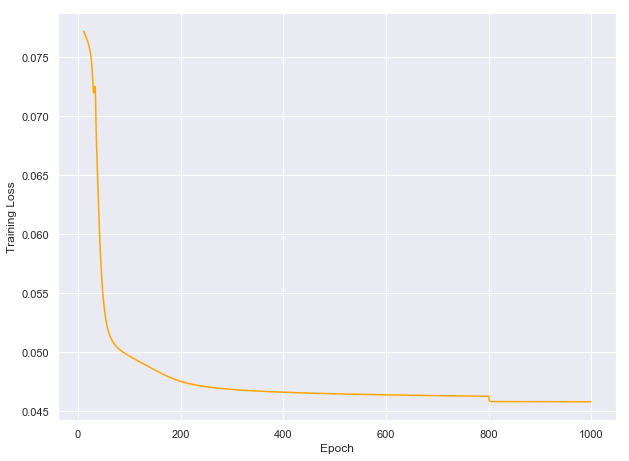

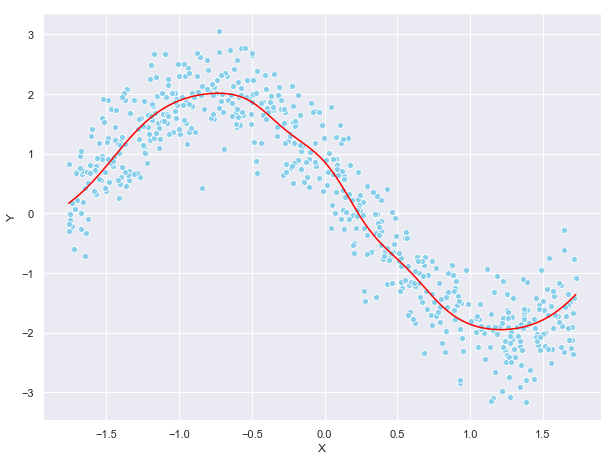

In [168]:
m = Model(lr=0.1,lrDecay=800,batchSize=128,momentum=0.9,statFreq=100)

m.Add(InputLayer(input_dim=1))

m.Add(DenseLayer(20,activation='sigmoid',name="L_1"))
m.Add(DenseLayer(20,activation='sigmoid',name="L_2"))
m.Add(DenseLayer(20,activation='sigmoid',name="L_3"))

m.Add(DenseLayer(1,activation='sigmoid',name="OutputLayer"))

m.compile()

x_train,x_test,y_train,y_test,output_scaler = Datasets.dataset_2()
epoch = 1000

m.train(x_train,y_train,epoch)
m.plotHistory()

pred = m.predict(x_test).ravel()
pred = output_scaler.inverse_transform(pred.reshape(-1,1))
y_real = output_scaler.inverse_transform(y_test).ravel()

Datasets.plot2D(x_test,y_real,False)
ax = sns.lineplot(x=x_test.ravel(),y=pred.ravel(),color='red')
plt.show()